# BoVD

In [ ]:
# ============ Load and understand dataset =================================
from datasets import load_dataset

# download the dataset
imagenet = load_dataset(
    "frgfm/imagenette",
    "full_size",
    split="train",
    ignore_verifications=True,  # set to True if seeing splits Error
)

import numpy as np

# generate an array from the original dataset
images_training = []

for n in range(0, len(imagenet)):
    images_training.append(np.array(imagenet[n]["image"]))

import cv2

# convert images to grayscale
bw_images = []
for img in images_training:
    # if RGB, transform into grayscale
    if len(img.shape) == 3:
        bw_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        # if grayscale, do not transform
        bw_images.append(img)


# ==================== Descriptors extracting =================
# ----------------------------------------------------------------
# should be batch processing in future
# ----------------------------------------------------------------

# defining feature extractor that we want to use (SIFT)
extractor = cv2.SIFT_create()

# initialize lists where we will store *all* keypoints and descriptors
keypoints = []
descriptors = []

for img in bw_images:
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

print(f"len before: {len(descriptors)}")
# initialize list to store idx values of records to drop
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    # if there are no descriptors, add record idx to drop list
    if img_descriptors is None:
        to_drop.append(i)

print(f"indexes: {to_drop}")
# delete from list in reverse order
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(f"len after: {len(descriptors)}")


# =============== Building codebook (like vocabulary) =================
import numpy as np

# select 1000 random image index values
np.random.seed(0)
sample_idx = np.random.randint(0, len(imagenet) + 1, 1000).tolist()
len(sample_idx)

# extract the sample from descriptors
# (we don't need keypoints)
descriptors_sample = []

for n in sample_idx:
    descriptors_sample.append(np.array(descriptors[n]))

all_descriptors = []
# extract image descriptor lists
for img_descriptors in descriptors_sample:
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
# convert to single numpy array
all_descriptors = np.stack(all_descriptors)

# perform k-means clustering to build the codebook
from scipy.cluster.vq import kmeans

k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters)

# saving codebook
import joblib

# save number of clusters and codebook
# Joblib dumps Python object into one file
joblib.dump((k, codebook), "bovw-codebook.pkl", compress=3)

# load the visual features, number of clusters, and codebook
k, codebook = joblib.load("bovw-codebook.pkl")

# ============= Building sparse vectors ====================
# 1. vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in descriptors:
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

# 2. frequency count
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)  # k = #cluster = #word in codebook
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

# 3. tf-idf
# N is the number of images, i.e. the size of the dataset
N = len(imagenet)  # 9469

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)
idf = np.log(N / df)
tfidf = frequency_vectors * idf

# Code

In [11]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
import cv2

import joblib
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq

<BarContainer object of 200 artists>

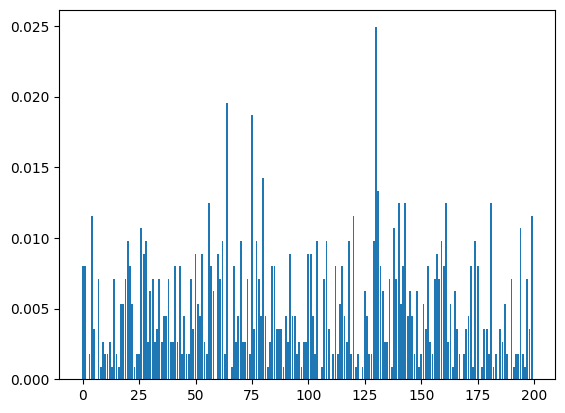

In [65]:
np.random.seed(0)  # reproducibility


class BagOfVisualWords:
    def __init__(
        self,
        root_dir: str = "/kaggle/input/the-hyper-kvasir-dataset/labeled_images",
        method: str = "sift",
        # k: int = 200,
        codebook_dir: str = None,
    ):
        self.root_dir = root_dir
        self.df = pd.read_csv(f"{root_dir}/image-labels.csv")
        self.labels = tuple(self.df["Finding"].unique())
        self.method = method

        if method == "sift":
            self.extractor = cv2.SIFT_create()
        elif method == "orb":
            self.extractor = cv2.ORB_create()
        elif method == "surf":
            self.extractor = cv2.xfeatures2d.SURF_create()
        else:
            raise ValueError(f"Unsupported feature detection method: {method}")

        # helper
        if codebook_dir is not None:
            self.k, self.codebook = joblib.load(codebook_dir)

        self.idf = 1
        self.samples_idx = []  # small sample idx for building visual vocabulary

    def extract_descriptors(self, sample_size=1000):
        """Extract descriptors from sample_size images
        :param method: method to extract descriptors e.g. ORB, SIFT, SURF, etc
        :param sample_size: size of sample. (We likely use a small sample in real-world scenario,
            where whole dataset is big)

        :return: all descriptors of sample_size images
        :rtype: list

        # TODO: sample for building visual vocabulary must be balance between classes
        every class include at least one image
        """
        self.sample_idx = np.random.randint(0, len(self.df) + 1, sample_size).tolist()

        descriptors_sample_all = (
            []
        )  # each image has many descriptors, descriptors_sample_all
        # is all descriptors of sample_size images

        # loop each image > extract > append
        for n in self.sample_idx:
            # descriptors extracting
            img_descriptors = self._get_descriptors(n)
            if img_descriptors is not None:
                for descriptor in img_descriptors:
                    descriptors_sample_all.append(np.array(descriptor))

        # convert to single numpy array
        descriptors_sample_all = np.stack(descriptors_sample_all)

        return descriptors_sample_all

    def build_codebook(
        self,
        all_descriptors: np.array,
        k: int = 200,
    ):
        """Building visual vocabulary (visual words)
        :param all_descriptors: array of descriptors
        :param k: #cluster (centroids)
        :param codebook_path: path to saving codebook

        :return: #centroids, codebook

        """
        kmeans = KMeans(n_clusters=k, random_state=123)
        kmeans.fit(all_descriptors)

        return kmeans.cluster_centers_

    def get_embedding(self, idx: int, normalized: bool = False, tfidf: bool = False):
        """Get embeddings of image[idx] (image > descriptors > project in codebook > frequencies vectors)
        :param idx: image index

        :return: frequencies vector (can consider as embedding)
        """
        img_descriptors = self._get_descriptors(idx)
        img_visual_words, distance = vq(img_descriptors, self.codebook)
        img_frequency_vector = np.histogram(
            img_visual_words, bins=self.k, density=normalized
        )[0]

        if tfidf:
            self._tf_idf()
            img_frequency_vector = img_frequency_vector * self.idf

        return img_frequency_vector

    def _tf_idf(self):
        """TODO: Reweight important features in codebook"""

        all_embeddings = []
        for i in range(len(self.df)):
            embedding = self.get_embedding(i)
            all_embeddings.append(embedding)

        all_embeddings = np.stack(all_embeddings)

        N = len(self.df)
        df = np.sum(all_embeddings > 0, axis=0)
        idf = np.log(N / df)

        return idf

    def _get_descriptors(self, idx, grayscale=True):
        """Extracting descriptors for each image[idx]
        :param method: method to extract features e.g. ORB, SIFT, SURF, etc
        :param idx: image index

        :return: descriptors
        :rtype: np.array
        """
        # get image
        img, _ = self._get_item(idx)
        # preprocessing: convert to grayscale for efficient computing
        if len(img.shape) == 3 and grayscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # descriptors extracting
        _, img_descriptors = self.extractor.detectAndCompute(img, None)

        return img_descriptors

    def _get_item(self, idx):
        """Return pair (image(arr), label)
        :param idx: index of data

        :return:
            tuple (image: array, label)
        """
        # get path of image
        GI_dir = {"Lower GI": "lower-gi-tract", "Upper GI": "upper-gi-tract"}

        img = self.df["Video file"][idx]
        gi_tract = GI_dir[self.df["Organ"][idx]]
        classification = self.df["Classification"][idx]
        finding = self.df["Finding"][idx]
        path = f"""{self.root_dir}/{gi_tract}/{classification}/{finding}/{img}.jpg"""
        assert (
            os.path.exists(path) == True
        ), "File does not exist"  # dir existance checking

        # read image
        image = np.array(Image.open(path))
        label = self.labels.index(finding)

        return image, label


model = BagOfVisualWords(
    root_dir="/media/mountHDD2/lamluuduc/endoscopy/dataset/hyperKvasir/labeled-images",
    codebook_dir="bovw_codebook_sift.pkl",
)

# # 1. extracting descriptors
# all_descriptors = model.extract_descriptors(sample_size=2000)
# joblib.dump(all_descriptors, f'sample_all_descriptors.pkl', compress=3) # saving all descriptors

# # 2. building visual vocabulary
# k = 200
# all_descriptors = joblib.load('all_descriptors_sift.pkl')
# codebook = model.build_codebook(all_descriptors, k)
# joblib.dump((k, codebook), f'bovw_codebook_{model.method}.pkl', compress=3) # saving codebook

embedding = model.get_embedding(0, normalized=True)
plt.bar(list(range(len(embedding))), embedding)

In [53]:
# =========== Sanity check =================================
# ====================== Unit tests =================================================
# test attributes
assert model.df.shape == (10662, 4)  # dataframe
assert len(model.labels) == 23

# test _get_item method
image, label = model._get_item(0)
assert len(image.shape) == 3  # image is a 3-dimensional array (h, w, c)
assert type(label) == int and 0 <= label <= 23  # label

# test _get_descriptors method
img_descriptors = model._get_descriptors(0)
assert len(img_descriptors.shape) == 2

# # test extract all descriptors process method
# # ensure output is 2d
# assert len(all_descriptors.shape) == 2, 'Invalid extracting process'
# assert len(model.sample_idx) == 1000, 'Invalid sampling'

# # test build_codebook method
assert model.codebook.shape == (model.k, 128), "Invalid building codebook process"

# test get_embedding method
embedding = model.get_embedding(0)
assert embedding.shape[0] == model.k

# Inference